Please, use Keras with **Tensorflow backend**. If you\'re using Keras with Theano backend, be aware of issue of channels first

### Imports

In [1]:
from keras.models import Sequential
from keras.layers.core import Dropout, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical

### Load CIFAR-10 dataset

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape) 

(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

In [5]:
label_encoder = {
        0:"airplane",
        1:"automobile",
        2:"bird",
        3:"cat",
        4:"deer",
        5:"dog",
        6:"frog",
        7:"horse",
        8:"ship",
        9:"truck"
}

In [6]:
def get_labels(labels_dict, dict_key):
    return labels_dict[int(dict_key)]

In [7]:
def plot_images(label_names, true_data=(X_train, y_train), y_pred=None):

    X, y = true_data
    num_pics = 9
    indices = np.random.randint(X.shape[0], size=num_pics)

    
    if y_pred is not None and len(y_pred) == len(y):
        acc_rate = (y == y_pred).sum() / len(y_pred)
        plt.figure(figsize=(9,8)).suptitle(f'accuracy: {acc_rate}%')
    else:
        plt.figure(figsize=(8,8))

    for i in range(num_pics):
        
        plt.subplot(331 + i)
        plt.subplots_adjust(hspace=0.7, wspace=2.1)
        if y_pred is not None and len(y_pred) == len(y):
            awesome_title = f'True: {get_labels(label_names, y[indices[i]])}\nPredicted: {get_labels(label_names, y_pred[indices[i]])}'
            plt.title(awesome_title, fontsize=14)
        else:
            plt.title(get_labels(label_names, y[indices[i]]), fontsize=16)
        plt.imshow(X[indices[i]])
    
    return plt.show()
        
    
    
        

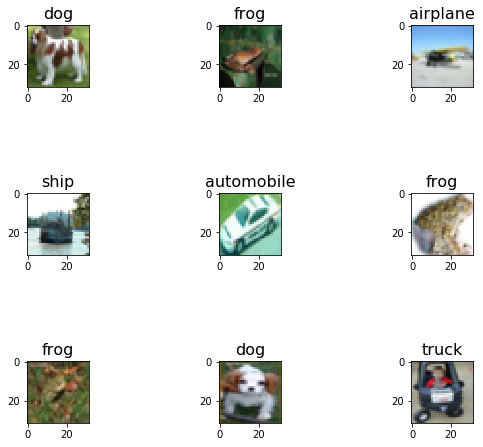

In [8]:
plot_images(label_encoder)

### Data preprocessing

Normalize images ([0...255] ---> [0...1])

In [9]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

Convert labels to one-hot encoding

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Build the model with Keras

### <center> VGGNet model architecture</center>
|  Layer  | Output size  | Filter size / stride |
|:--------|:-------------|:---------------------|
| INPUT   | 32 x 32 x 3  |${~~~~~~~~~~~~~~~~~~}$|
|  CONV   | 32 x 32 x 32 | 3 x 3, K = 32        |
| ACT     | 32 x 32 x 32 |${~~~~~~~~~~~~~~~~~~}$|
| BN      | 32 x 32 x 32 |${~~~~~~~~~~~~~~~~~~}$|
|  CONV   | 32 x 32 x 32 | 3 x 3, K = 32        |
| ACT     | 32 x 32 x 32 |${~~~~~~~~~~~~~~~~~~}$|
| BN      | 32 x 32 x 32 |${~~~~~~~~~~~~~~~~~~}$|
| POOL    | 16 x 16 x 32 |    2 x 2             |
| DROPOUT | 16 x 16 x 32 |${~~~~~~~~~~~~~~~~~~}$|
|  CONV   | 16 x 16 x 64 | 3 x 3, K = 64        |
| ACT     | 16 x 16 x 64 |${~~~~~~~~~~~~~~~~~~}$|
| BN      | 16 x 16 x 64 |${~~~~~~~~~~~~~~~~~~}$|
|  CONV   | 16 x 16 x 64 | 3 x 3, K = 64        |
| ACT     | 16 x 16 x 64 |${~~~~~~~~~~~~~~~~~~}$|
| BN      | 16 x 16 x 64 |${~~~~~~~~~~~~~~~~~~}$|
| POOL    |  8 x  8 x 64 |    2 x 2             |
| DROPOUT |  8 x  8 x 64 |${~~~~~~~~~~~~~~~~~~}$|
| FC      |  512         |${~~~~~~~~~~~~~~~~~~}$|
| ACT     |  512         |${~~~~~~~~~~~~~~~~~~}$|
| BN      |  512         |${~~~~~~~~~~~~~~~~~~}$|
| DROPOUT |  512         |${~~~~~~~~~~~~~~~~~~}$|
| FC      |  10          |${~~~~~~~~~~~~~~~~~~}$|
| SOFTMAX |  10          |${~~~~~~~~~~~~~~~~~~}$|


In [11]:
model = Sequential()
# Conv layer with 32 filters
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
# Conv layer with 32 filters
model.add(Conv2D(32, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
# 2 x 2 max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Conv layer with 64 filters
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
# Conv layer with 64 filters
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
# 2 x 2 max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Fully-connected layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
# Output
model.add(Dropout(0.5))
model.add(Dense(10))

model.add(Activation("softmax"))

### Compile and train the model

In [12]:
batch_size = 64
alpha = 0.003
num_epochs = 50
verbose = 1

This model is using batch normalization (BN), which slows down the speed of the training

In [13]:
optimizer = SGD(lr=alpha, decay=0.00025, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
train_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=num_epochs)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.6309 - acc: 0.4538 - val_loss: 1.1390 - val_acc: 0.5955
Epoch 2/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.1463 - acc: 0.5923 - val_loss: 1.0631 - val_acc: 0.6179
Epoch 3/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.0085 - acc: 0.6404 - val_loss: 0.8999 - val_acc: 0.6869
Epoch 4/50
50000/50000 [==============================] - 12s 239us/step - loss: 0.9292 - acc: 0.6698 - val_loss: 0.8277 - val_acc: 0.7083
Epoch 5/50
50000/50000 [==============================] - 12s 240us/step - loss: 0.8711 - acc: 0.6921 - val_loss: 0.7970 - val_acc: 0.7140
Epoch 6/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.8246 - acc: 0.7083 - val_loss: 0.7599 - val_acc: 0.7340
Epoch 7/50
50000/50000 [==============================] - 12s 238us/step - loss: 0.7848 - acc: 0.7230 - val_loss: 0.

### See the results of the training

In [14]:
loss_acc_dict = train_history.history
y_pred = model.predict(X_test, batch_size=batch_size)


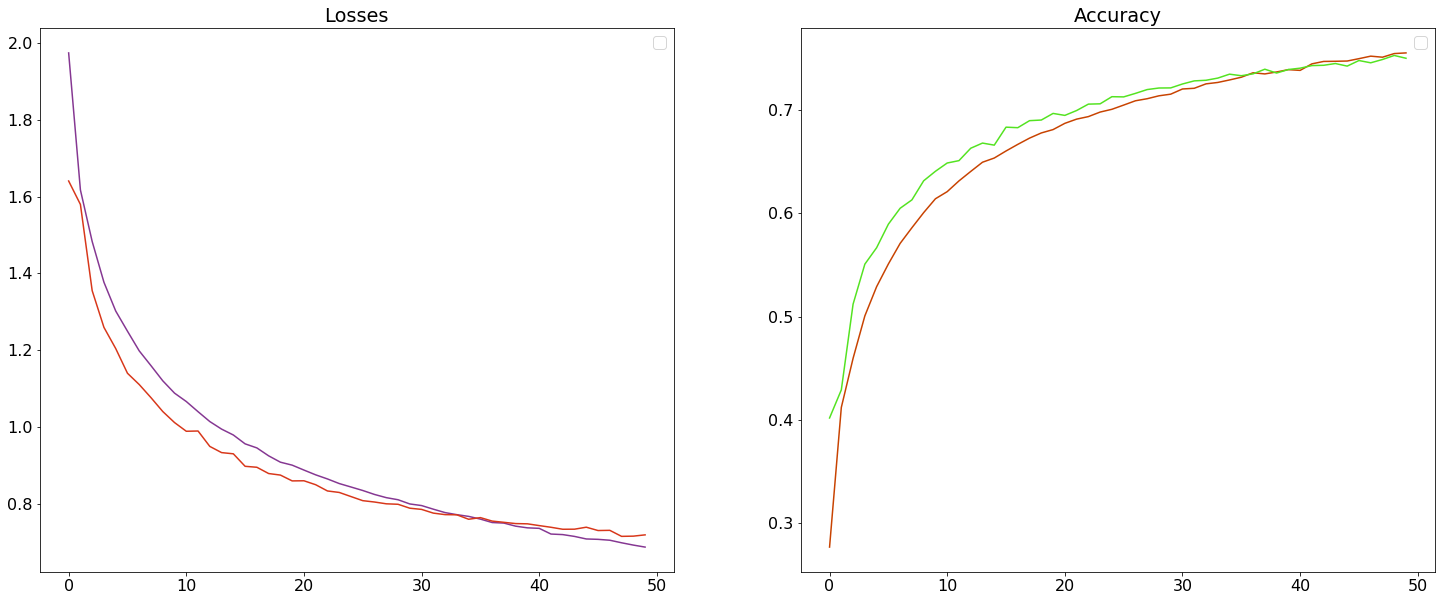

In [27]:
plt.figure(figsize=(25,10))
# update font size
plt.rcParams.update({'font.size': 16})

plt.subplot(121)
plt.title("Losses")
plt.legend(("Training losses", "Test losses"))
plt.plot(np.arange(0, num_epochs), loss_acc_dict["loss"], c="#853792")
plt.plot(np.arange(0, num_epochs), loss_acc_dict["val_loss"], c="#d8371a")

plt.subplot(122)
plt.title("Accuracy")
plt.legend(("Training Accuracy", "Test Accuracy"))
plt.plot(np.arange(0, num_epochs), loss_acc_dict["acc"], c="#c84301")
plt.plot(np.arange(0, num_epochs), loss_acc_dict["val_acc"], c="#54e321")

plt.show()

                            Classification report

In [16]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1000
           1       0.92      0.90      0.91      1000
           2       0.79      0.69      0.74      1000
           3       0.66      0.61      0.64      1000
           4       0.73      0.84      0.78      1000
           5       0.71      0.71      0.71      1000
           6       0.83      0.90      0.86      1000
           7       0.88      0.85      0.86      1000
           8       0.89      0.91      0.90      1000
           9       0.87      0.90      0.88      1000

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



                            Confusion matrix

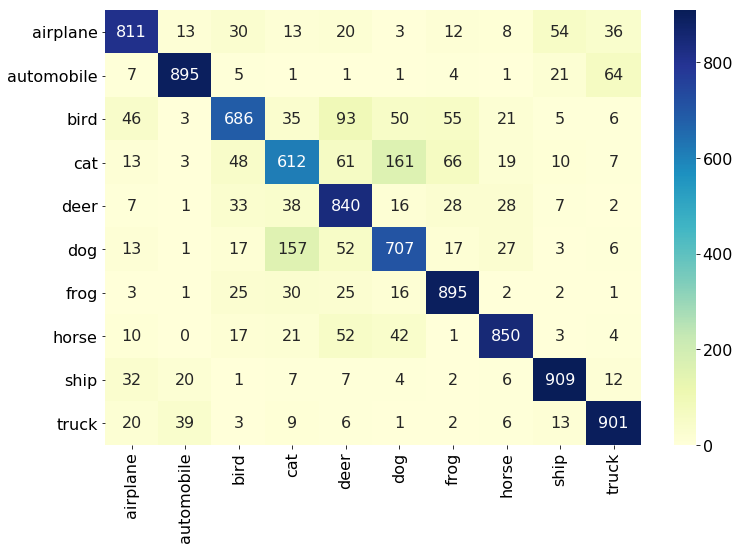

In [17]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
pd_cm = pd.DataFrame(cm, index=[l for l in label_encoder.values()], columns=[c for c in label_encoder.values()])

plt.figure(figsize=(12,8))
sn.heatmap(pd_cm, annot=True, cmap="YlGnBu", fmt='d')
plt.show()

                            Show images

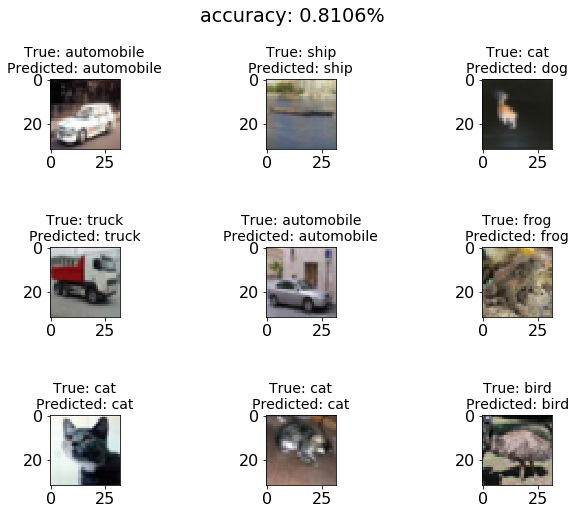

In [18]:
plot_images(label_encoder, (X_test, y_test.argmax(axis=1)), y_pred.argmax(axis=1))

## The same model without Batch normalization

In [19]:
model = Sequential()
# Conv layer with 32 filters
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
# Conv layer with 32 filters
model.add(Conv2D(32, (3,3), padding="same"))
model.add(Activation("relu"))
# 2 x 2 max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Conv layer with 64 filters
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
# Conv layer with 64 filters
model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
# 2 x 2 max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Fully-connected layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
# Output
model.add(Dropout(0.5))
model.add(Dense(10))

model.add(Activation("softmax"))

In [20]:
batch_size = 64
alpha = 0.003
num_epochs = 50
verbose = 1

In [21]:
optimizer = SGD(lr=alpha, decay=0.00025, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
train_history_no_bn = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=num_epochs)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.9742 - acc: 0.2770 - val_loss: 1.6406 - val_acc: 0.4020
Epoch 2/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.6173 - acc: 0.4122 - val_loss: 1.5795 - val_acc: 0.4292
Epoch 3/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.4830 - acc: 0.4597 - val_loss: 1.3549 - val_acc: 0.5122
Epoch 4/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.3768 - acc: 0.5008 - val_loss: 1.2592 - val_acc: 0.5509
Epoch 5/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.3019 - acc: 0.5291 - val_loss: 1.2041 - val_acc: 0.5668
Epoch 6/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.2493 - acc: 0.5511 - val_loss: 1.1397 - val_acc: 0.5896
Epoch 7/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.1980 - acc: 0.5710 - val_loss: 1.1103 - 

In [22]:
loss_acc_dict = train_history_no_bn.history
y_pred_no_bn = model.predict(X_test, batch_size=batch_size)

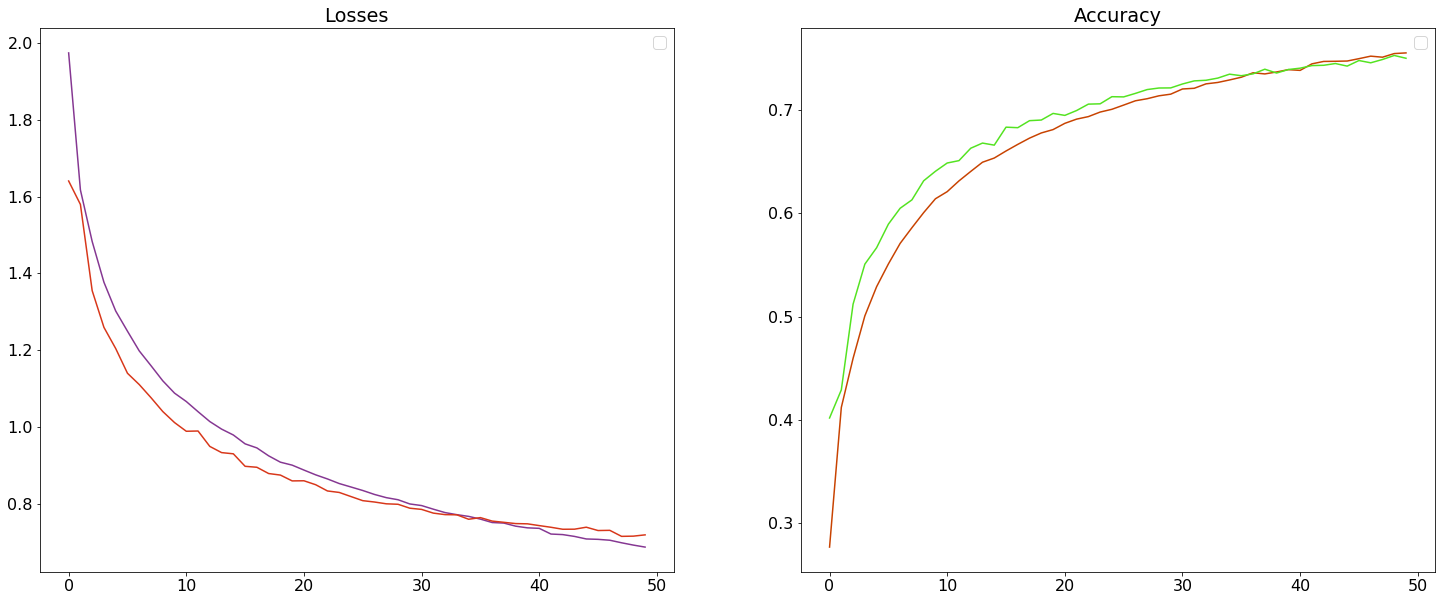

In [26]:
plt.figure(figsize=(25,10))
# update font size
plt.rcParams.update({'font.size': 16})

plt.subplot(121)
plt.title("Losses")
plt.legend(("Training losses", "Test losses"))
plt.plot(np.arange(0, num_epochs), loss_acc_dict["loss"], c="#853792")
plt.plot(np.arange(0, num_epochs), loss_acc_dict["val_loss"], c="#d8371a")

plt.subplot(122)
plt.title("Accuracy")
plt.legend(("Training Accuracy", "Test Accuracy"))
plt.plot(np.arange(0, num_epochs), loss_acc_dict["acc"], c="#c84301")
plt.plot(np.arange(0, num_epochs), loss_acc_dict["val_acc"], c="#54e321")

plt.show()

In [24]:
print(classification_report(y_test.argmax(axis=1), y_pred_no_bn.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1000
           1       0.86      0.89      0.87      1000
           2       0.69      0.61      0.65      1000
           3       0.63      0.50      0.56      1000
           4       0.65      0.72      0.68      1000
           5       0.65      0.67      0.66      1000
           6       0.72      0.89      0.80      1000
           7       0.81      0.79      0.80      1000
           8       0.83      0.86      0.85      1000
           9       0.84      0.83      0.84      1000

   micro avg       0.75      0.75      0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



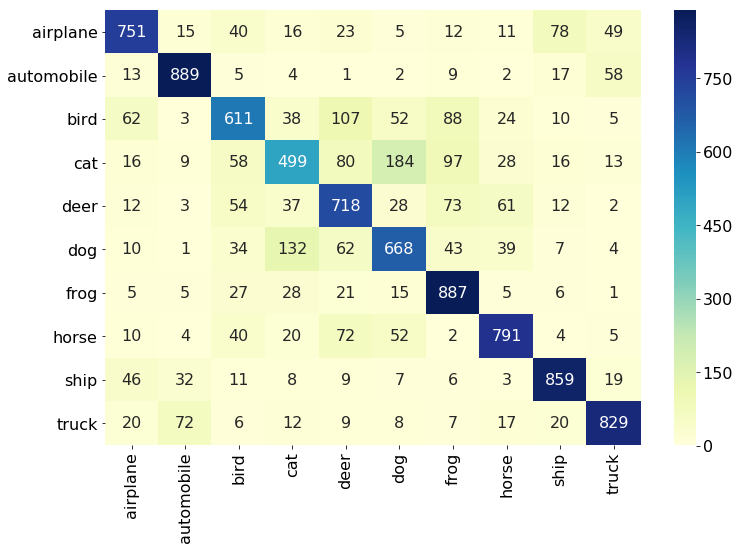

In [25]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_no_bn.argmax(axis=1))
pd_cm = pd.DataFrame(cm, index=[l for l in label_encoder.values()], columns=[c for c in label_encoder.values()])

plt.figure(figsize=(12,8))
sn.heatmap(pd_cm, annot=True, cmap="YlGnBu", fmt='d')
plt.show()

## Compare results with batch normalization and without it

Training time per epoch is 12s with BN vs 8-9s without BN

In [36]:
print(f'Number of epochs: {num_epochs}')
print(f'Accuracy with BN: {100*(y_pred.argmax(axis=1) == y_test.argmax(axis=1)).sum() / len(y_test)}%')
print(f'Accuracy without BN {100*(y_pred_no_bn.argmax(axis=1) == y_test.argmax(axis=1)).sum() / len(y_test)}%')

Number of epochs: 50
Accuracy with BN: 81.06%
Accuracy without BN 75.02%
